In [1]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import json

/home/ubuntu/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

### MNIST

In [2]:
training_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
)

testing_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),
)

### CIFAR10

In [4]:
training_data = datasets.CIFAR10(
    root="../../perFL/benchmark/cifar10/data",
    train=True,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

testing_data = datasets.CIFAR10(
    root="../../perFL/benchmark/cifar10/data",
    train=False,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

### CIFAR100

In [35]:
training_data = datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

testing_data = datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
)

Files already downloaded and verified
Files already downloaded and verified


## Division algorithm

**Each client:**

1. Contains no more than 3 labels
2. Each label has 8 to 20 samples
3. There're at least 5 * #numclass clients

In [5]:
import numpy as np
import os
import math

In [8]:
import numpy as np
import math

total_labels = np.unique(training_data.targets).tolist()
print(total_labels)

alpha = 1

min_sample_per_client = 15
max_sample_per_client = 60

num_clients = 500

total_label = len(total_labels)
label_list = [i for i in total_labels]

labels = training_data.targets
idxs = range(len(training_data))
training_idxs_labels = np.vstack((idxs, labels)).T

labels = testing_data.targets
idxs = range(len(testing_data))
testing_idxs_labels = np.vstack((idxs, labels)).T

training_dict_client = {client_id:[] for client_id in range(num_clients)}
testing_dict_client = {client_id:[] for client_id in range(num_clients)}

label_dist = np.random.dirichlet([alpha/total_label for i in range(total_label)], num_clients)
label_nums = np.zeros([num_clients, total_label])

for client_idx in range(num_clients):
    local_label_dist = label_dist[client_idx].tolist()
    sample_this_client = np.random.randint(min_sample_per_client, max_sample_per_client + 1)
    
    for label, proportion in zip(label_list, local_label_dist):
        sample_this_label = round(proportion * sample_this_client)
        if sample_this_label > 0:
            label_nums[client_idx, label] = sample_this_label
            
            idxes_1 = training_idxs_labels[training_idxs_labels[:,1] == label][:,0]
            idxes_2 = testing_idxs_labels[testing_idxs_labels[:,1] == label][:,0]
            
            label_1_idxes = np.random.choice(idxes_1, sample_this_label, replace=False)
            label_2_idxes = np.random.choice(idxes_2, max(5, int(np.ceil(sample_this_label/2))), replace=True)
            
            training_dict_client[client_idx] += label_1_idxes.tolist()
            testing_dict_client[client_idx] += label_2_idxes.tolist()
            
            training_idxs_labels[label_1_idxes] -= 100
            # testing_idxs_labels[label_2_idxes] -= 100


class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
savepath = f"./dataset_idx/cifar10/dirichlet/dir_{alpha}_sparse/{num_clients}client"
if not Path(savepath).exists():
    os.makedirs(savepath)
    
json.dump(training_dict_client, open(f"{savepath}/train.json", "w"), cls=NumpyEncoder)
json.dump(testing_dict_client, open(f"{savepath}/test.json", "w"), cls=NumpyEncoder)
np.savetxt(f"{savepath}/stats.csv", label_nums, fmt="%d", delimiter=",")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


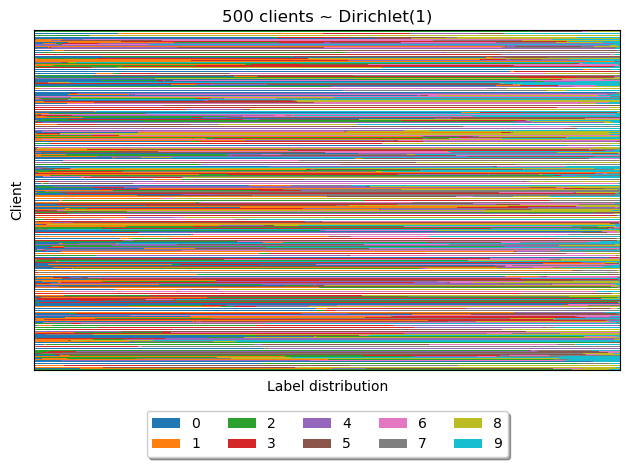

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(label_dist)
# df.index = [f"Client {i}" for i in range(5)]
ax = df.plot(kind='barh', stacked=True, width=0.8)
ax.set_title(f"{num_clients} clients ~ Dirichlet({alpha})")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=5, fancybox=True, shadow=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel("Client")
ax.set_xlabel("Label distribution")

plt.tight_layout()
plt.savefig(f"{savepath}/distribution.png")